In [417]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

from skimage.segmentation import clear_border
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
from skimage.measure import label,regionprops

In [418]:
lung = plt.imread("lung3.jpg")
cameraman = plt.imread("cameraman.tif")

print(lung.shape)
print(cameraman.shape)

(352, 612, 3)
(256, 256)


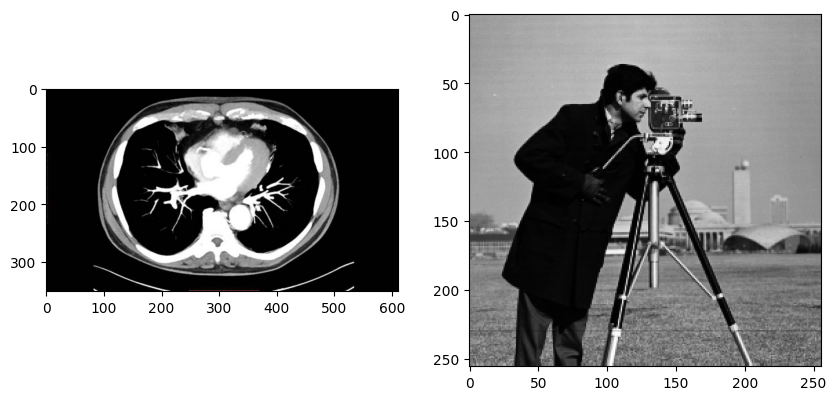

In [419]:
plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.imshow(lung)


plt.subplot(122)
plt.imshow(cameraman, cmap='gray')

In [420]:
def Mirror_Padding_v2(img, nx, ny):
    height, width = img.shape
    height_new = height + 2*nx
    width_new = width + 2*ny
    output = np.zeros([height_new, width_new])
    # Center
    output[nx:height_new-nx, ny:width_new-ny] = img
    # Top and Bottom
    output[:nx, ny:width_new-ny] = img[nx-1::-1, :] # Top
    output[height+nx:, ny:width_new-ny] = img[height-1:height-nx-1:-1, :] # Bottom
    # Left and Right
    output[:height_new, :ny] = output[:, 2*ny:ny:-1] # Left
    output[:height_new, width_new-ny:width_new] = output[:, width_new-ny-1:width_new-2*ny-1:-1] # Right
    return output

def Sobel_Filter(img, return_abs=False):
    # Get Constant metrices
    wx = np.array([[-1.0,-2.0,-1.0], [0.0,0.0,0.0], [1.0,2.0,1.0]])
    wy = np.array([[-1.0,0.0,1.0], [-2.0,0.0,2.0], [-1.0,0.0,1.0]])
    # Get Constant metrices
    img = Mirror_Padding_v2(img, 3, 3)
    m, n = img.shape
    output = np.zeros([m, n])
    for x in range(3, m-3):
        for y in range(3, n-3):
            elements = img[x-3//2:x+3//2+1, y-3//2:y+3//2+1]
            gx = np.sum(np.multiply(wx, elements))
            gy = np.sum(np.multiply(wy, elements))
            if return_abs == True:
                output[x, y] = np.abs(gx) + np.abs(gy)
            else:    
                output[x, y] = np.sqrt(gx**2 + gy**2)
    return output[3:m-3, 3:n-3]

def Sobel_Filter_3D(img, return_abs=False):
    output = img.copy()
    for i in range(3):
        output[:,:,i] = Sobel_Filter(output[:, :, i], return_abs)
    return output

In [421]:
lung_sobel = Sobel_Filter_3D(lung)
cameraman_sobel = Sobel_Filter(cameraman)

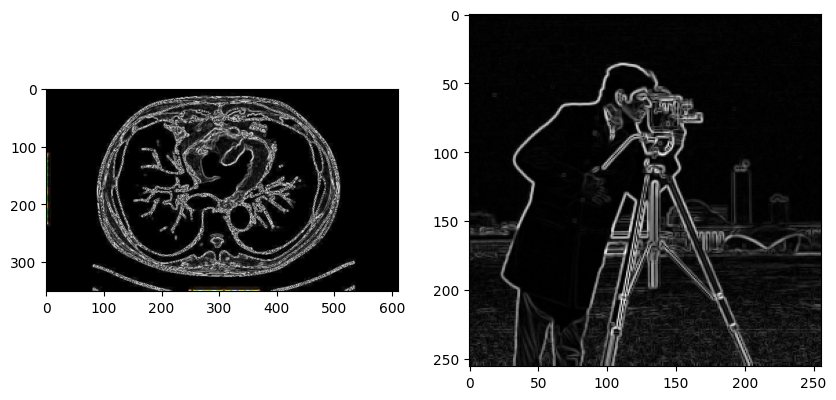

In [422]:
plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.imshow(lung_sobel)


plt.subplot(122)
plt.imshow(cameraman_sobel, cmap='gray')

In [423]:
def Segment_Clustering(img, n):
    len_ = len(img.shape)
    X = img.reshape(-1, len_-1)
    kmeans = KMeans(n_clusters=n).fit(X)
    output = kmeans.cluster_centers_[kmeans.labels_]
    output = output.reshape(img.shape)
    return output

def Segment_Clustering_3D(img, n):
    output = img.copy()
    for i in range(3):
        output[:,:,i] = Segment_Clustering(output[:, :, i], n)
    return output

def Grayscale(img):
    R = np.array(img[:, :, 0].astype(np.float32))
    G = np.array(img[:, :, 1].astype(np.float32))
    B = np.array(img[:, :, 2].astype(np.float32))
    return np.array((R+G+B) / 3)

In [424]:
segment_cameraman = Segment_Clustering(cameraman_sobel+cameraman, 3)
segment_lung = Segment_Clustering(Grayscale(lung), 2)

/home/dang/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/dang/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


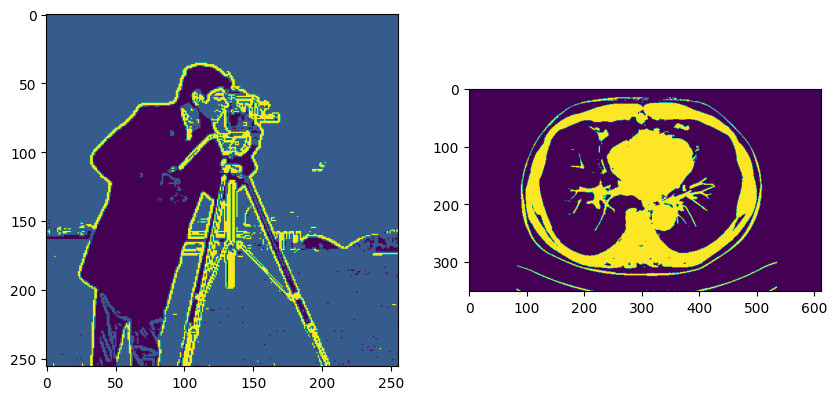

In [425]:
plt.figure(figsize=(10, 8))

plt.subplot(121)
plt.imshow(segment_cameraman)


plt.subplot(122)
plt.imshow(segment_lung)

In [426]:
lung_gray = Grayscale(lung)

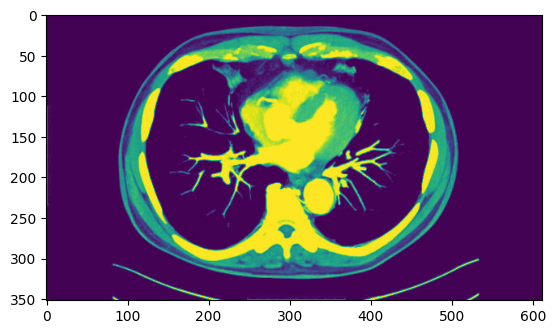

In [427]:
plt.imshow(lung_gray)

(array([149913.,   6068.,   4313.,   3961.,   4552.,   8433.,   9737.,
          4149.,   2856.,  21442.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

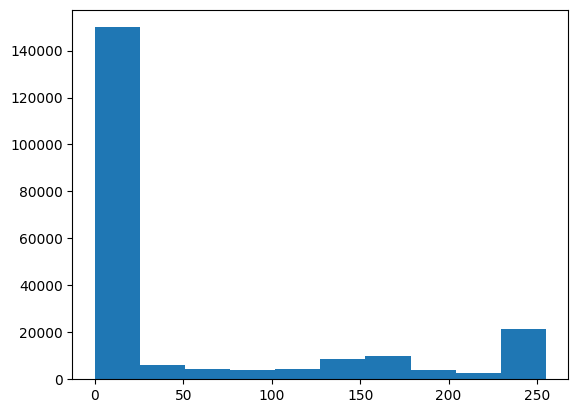

In [428]:
plt.hist(lung_gray.ravel())

In [429]:
mask = lung_gray < 100
mask.shape

(352, 612)

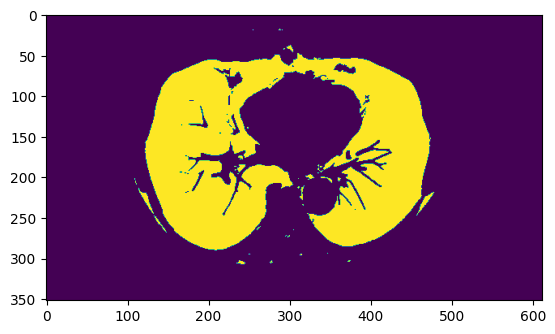

In [430]:
mask = np.vectorize(clear_border,  signature='(n,m)->(n,m)')(mask)
plt.imshow(mask)

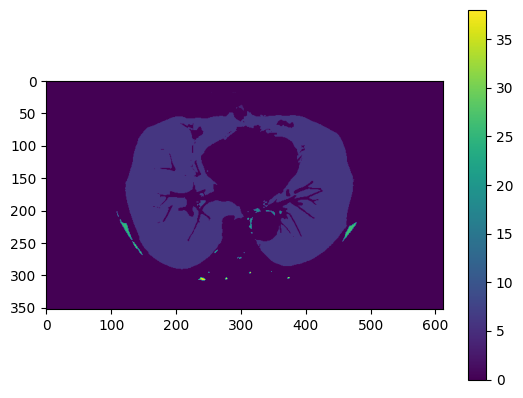

In [431]:
mask_label = np.vectorize(label,  signature='(n,m)->(n,m)')(mask)
plt.imshow(mask_label)
plt.colorbar()

In [432]:
center_of_mass(mask_label==25)[0]


228.3507462686567

In [433]:
def clear_all(slc, left=0.1, right=0.5):
    new_slc = slc.copy()
    labels = label(slc, background=0)
    idxs = np.unique(labels)[1:]
    COM_ys = np.array([center_of_mass(labels==i)[0] for i in idxs])
    for idx, COM_y in zip(idxs, COM_ys):
        if (COM_y < left*slc.shape[0]):
            new_slc[labels==idx] = 0
        elif (COM_y > right*slc.shape[0]):
            new_slc[labels==idx] = 0
    return new_slc

In [434]:
mask_new = np.vectorize(clear_all, signature='(n,m)->(n,m)')(mask)


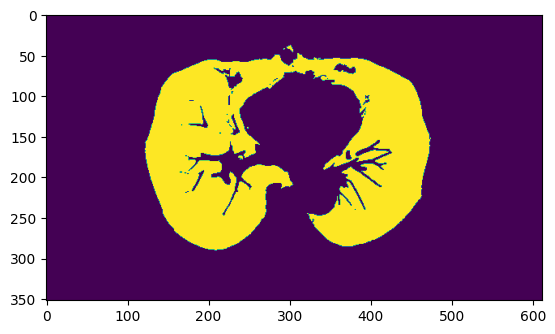

In [435]:
plt.imshow(mask_new)

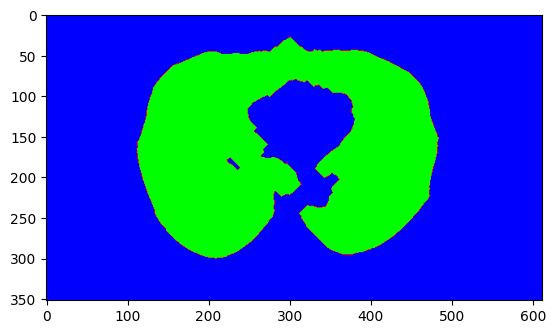

In [436]:
mask_new = binary_dilation(mask_new, iterations=10)
plt.imshow(mask_new, cmap="brg")